2026-02-15 15:15:23,259 [INFO] Loading data from ../data/randhrs1992_2022v1.dta...
/tmp/ipykernel_887379/1455137385.py:189: FutureWarning: The StataReader.close() method is not part of the public API and will be removed in a future version without notice. Using StataReader as a context manager is the only supported method.
  reader.close()
/tmp/ipykernel_887379/1455137385.py:196: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', axis=1).fillna(0)
2026-02-15 15:15:38,406 [INFO] Splitting data by ID (preventing leakage)...
2026-02-15 15:15:38,440 [INFO] Fitting scaler on training data only...
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, 


FINAL PROCESS RESULTS
ROC AUC:    0.7933
PR AUC:     0.3674
F2 SCORE:   0.6336 (at threshold 0.38)



2026-02-15 15:25:01,436 [INFO] Baseline AUC for Importance: 0.7933
/tmp/ipykernel_887379/1455137385.py:482: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Importance", y="Feature", palette="viridis")


     Feature  Importance
1       cesd    0.198199
3       iadl    0.143082
2        adl    0.135117
15    height    0.051800
7       work    0.047055
4    vig_act    0.035552
12    smoken    0.029131
9     weight    0.027832
6     income    0.026639
10    drinkr    0.021722
11     evbrn    0.020363
5     wealth    0.020236
8     livsib    0.018241
13    smokev    0.012867
14    urbrur    0.011208
20   rabyear    0.007596
0        bmi    0.007191
16  ragender    0.001005
19   raedyrs    0.000561
17   raracem    0.000281
18  rahispan    0.000253


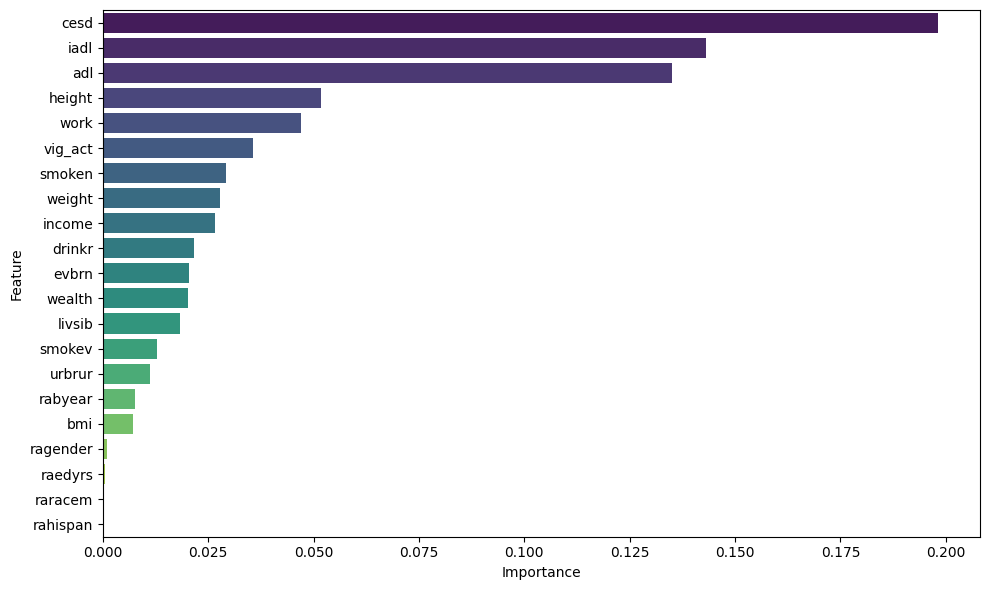

In [5]:
"""
=============================================================================
RAND HRS: Bi-LSTM + Attention (No Leakage) + Full Evaluation
=============================================================================
Summary:
- Input: Rolling window of 4 waves (Risk Factors Only).
- Target: Health Decline in next wave (derived from excluded variables).
- Model: Bidirectional LSTM with Temporal Attention.
- Evaluation: ROC, PR, F2-Score optimization, Confusion Matrix.
=============================================================================
"""

import os
import gc
import logging
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, 
    roc_curve, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, 
    classification_report
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ─────────────────────────────────────────────────────────────────────────────
# 1. CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────
CFG = {
    "dta_path": "../data/randhrs1992_2022v1.dta",
    "output_dir": "./outputs_lstm_final",
    "seq_len": 4,             
    "batch_size": 128,        
    "epochs": 10,             
    "lr": 5e-4,               
    "hidden_dim": 128,        
    "lstm_layers": 3,         
    "dropout": 0.4,           
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
log = logging.getLogger(__name__)
os.makedirs(CFG["output_dir"], exist_ok=True)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

seed_everything(CFG["seed"])

# ─────────────────────────────────────────────────────────────────────────────
# 2. FEATURE DEFINITION (STRICT NO LEAKAGE)
# ─────────────────────────────────────────────────────────────────────────────
MAX_WAVES = 15
def get_wave_cols(prefix, suffix, max_w=MAX_WAVES):
    return [f"{prefix}{w}{suffix}" for w in range(1, max_w + 1)]

# INPUT FEATURES (X) - Risk Factors Only
INPUT_FEATURES = {
    "bmi":      get_wave_cols("r", "bmi"),
    "cesd":     get_wave_cols("r", "cesd"),      # Depression
    "adl":      get_wave_cols("r", "adla"),
    "iadl":     get_wave_cols("r", "iadlza"),
    "vig_act":  get_wave_cols("r", "vgactx"),    # Exercise
    "wealth":   get_wave_cols("h", "atotb"),     # Socioeconomic
    "income":   get_wave_cols("h", "itot"),      # Total Household Income
    "work":     get_wave_cols("r", "work"),
    "livsib":   get_wave_cols("r", "livsib"),
    "weight":   get_wave_cols("r", "weight"),
    "drinkr":   get_wave_cols("r", "drinkr"),
    "evbrn":    get_wave_cols("r", "evbrn"),
    "smoken":   get_wave_cols("r", "smoken"),
    "smokev":   get_wave_cols("r", "smokev"),
    "urbrur":   get_wave_cols("r", "urbrur"),
    "height":   get_wave_cols("r", "height"),
}

# TARGET SOURCES (y) - Excluded from Input
TARGET_SOURCE_FEATURES = {
    "srh":      get_wave_cols("r", "shlt"),    
    "cond":     get_wave_cols("r", "conde"),   
}

STATIC_COLS = ["ragender", "raracem", "rahispan", "raedyrs", "rabyear"]
ID_COL = "hhidpn"

# ─────────────────────────────────────────────────────────────────────────────
# 3. DATASET CLASS
# ─────────────────────────────────────────────────────────────────────────────
class SimpleDS(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# ─────────────────────────────────────────────────────────────────────────────
# 4. PREPROCESSING (LEAKAGE FIX)
# ─────────────────────────────────────────────────────────────────────────────
class HRSPreprocessor:
    """Handles scaling and clipping fitted ONLY on training data."""
    def __init__(self):
        self.scalers = {}
        self.limits = {}
        self.static_scaler = RobustScaler()
        self.is_fitted = False

    def fit(self, df):
        """Learns stats from Training Set Only."""
        # Fit Dynamic Features
        for feat_name, cols in INPUT_FEATURES.items():
            vals = df[cols].values.flatten().reshape(-1, 1)
            # Clip logic
            lim = np.percentile(vals, 99)
            self.limits[feat_name] = lim
            if lim > 0:
                vals = np.clip(vals, -lim, lim)
            
            # Scaler logic
            scl = RobustScaler()
            scl.fit(vals)
            self.scalers[feat_name] = scl

        # Fit Static Features
        static_vals = df[STATIC_COLS].values
        self.static_scaler.fit(static_vals)
        self.is_fitted = True

    def transform(self, df):
        """Applies learned stats to Train or Test set."""
        if not self.is_fitted:
            raise ValueError("Preprocessor must be fitted on training data first.")
        
        df_out = df.copy()
        
        # Transform Dynamic
        for feat_name, cols in INPUT_FEATURES.items():
            vals = df_out[cols].values
            orig_shape = vals.shape
            vals = vals.flatten().reshape(-1, 1)
            
            # Apply saved clip
            lim = self.limits[feat_name]
            if lim > 0:
                vals = np.clip(vals, -lim, lim)
            
            # Apply saved scaler
            vals = self.scalers[feat_name].transform(vals)
            df_out[cols] = vals.reshape(orig_shape)

        # Transform Static
        df_out[STATIC_COLS] = self.static_scaler.transform(df_out[STATIC_COLS])
        
        return df_out

def load_data_raw(path):
    """Loads data and performs basic imputation (No Scaling)."""
    log.info(f"Loading data from {path}...")
    
    input_cols = [c for cols in INPUT_FEATURES.values() for c in cols]
    target_cols = [c for cols in TARGET_SOURCE_FEATURES.values() for c in cols]
    all_needed = [ID_COL] + STATIC_COLS + input_cols + target_cols
    
    try:
        df_cols = pd.read_stata(path, nrows=0).columns.tolist()
    except:
        reader = pd.read_stata(path, iterator=True)
        df_cols = list(reader.variable_labels().keys())
        reader.close()
        
    valid_cols = [c for c in all_needed if c in df_cols]
    df = pd.read_stata(path, columns=valid_cols, convert_categoricals=False)
    df = df.reindex(columns=all_needed)
    
    # Impute missing values with 0 or ffill (Basic cleanup)
    df = df.fillna(method='ffill', axis=1).fillna(0)
    
    return df

def create_sequences(df):
    """Converts Wide DF to Sequences using pre-calculated targets."""
    # Extract Target Sources (Raw values, unscaled)
    raw_srh = df[TARGET_SOURCE_FEATURES["srh"]].values
    raw_cond = df[TARGET_SOURCE_FEATURES["cond"]].values
    
    sequences, targets, groups = [], [], []
    valid_starts = range(1, MAX_WAVES - CFG["seq_len"] + 1)
    
    id_arr = df[ID_COL].values
    static_arr = df[STATIC_COLS].values
    temp_arrays = {k: df[v].values for k, v in INPUT_FEATURES.items()}
    
    for start_w in valid_starts:
        input_idxs = [w-1 for w in range(start_w, start_w + CFG["seq_len"])]
        last_in_idx = input_idxs[-1]
        target_idx  = last_in_idx + 1
        
        # Build Input X
        batch_inputs = []
        for t in input_idxs:
            step_feats = [temp_arrays[k][:, t:t+1] for k in INPUT_FEATURES.keys()]
            batch_inputs.append(np.concatenate(step_feats, axis=1))
        X_time = np.stack(batch_inputs, axis=1)
        
        # Add Static
        X_static = np.tile(static_arr[:, np.newaxis, :], (1, CFG["seq_len"], 1))
        X_full = np.concatenate([X_time, X_static], axis=2)
        
        # Calculate Target (Change in Raw Srh or Cond)
        # Note: raw_srh/cond indices align with wave numbers (0 = wave 1)
        srh_diff = raw_srh[:, target_idx] - raw_srh[:, last_in_idx]
        cond_diff = raw_cond[:, target_idx] - raw_cond[:, last_in_idx]
        y = ((srh_diff >= 1.0) | (cond_diff >= 1.0)).astype(int)
        
        sequences.append(X_full)
        targets.append(y)
        groups.append(id_arr)
        
    return np.concatenate(sequences, axis=0), np.concatenate(targets, axis=0), np.concatenate(groups, axis=0)

# ─────────────────────────────────────────────────────────────────────────────
# 5. MODEL
# ─────────────────────────────────────────────────────────────────────────────
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, lstm_output):
        attn_weights = F.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context, attn_weights

class BiLSTM_Attn(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, CFG["hidden_dim"], CFG["lstm_layers"], 
                            batch_first=True, bidirectional=True, dropout=CFG["dropout"])
        self.attn = Attention(CFG["hidden_dim"])
        self.fc = nn.Sequential(
            nn.Linear(CFG["hidden_dim"] * 2, 64),
            nn.ReLU(),
            nn.Dropout(CFG["dropout"]),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        context, _ = self.attn(out)
        return self.fc(context)

# ─────────────────────────────────────────────────────────────────────────────
# 6. EVALUATION FUNCTIONS
# ─────────────────────────────────────────────────────────────────────────────
def evaluate_performance(y_true, y_probs, save_dir):
    """Generates plots and calculates metrics."""
    
    # 1. Basic Curves
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    pr_auc = average_precision_score(y_true, y_probs)
    
    # 2. Optimal Threshold for F2 Score
    best_f2 = 0
    best_thresh = 0.5
    
    for t in np.arange(0.01, 1.0, 0.01):
        y_pred_t = (y_probs >= t).astype(int)
        score = fbeta_score(y_true, y_pred_t, beta=2)
        if score > best_f2:
            best_f2 = score
            best_thresh = t
            
    # 3. Final Predictions using Best Threshold
    y_pred_final = (y_probs >= best_thresh).astype(int)
    
    # 4. Save Plots
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f"{save_dir}/roc_curve.png")
    plt.close()
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(f"{save_dir}/pr_curve.png")
    plt.close()
    
    cm = confusion_matrix(y_true, y_pred_final)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stable", "Decline"])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f'Confusion Matrix (Threshold={best_thresh:.2f})')
    plt.savefig(f"{save_dir}/confusion_matrix.png")
    plt.close()
    
    return best_thresh, roc_auc, pr_auc, best_f2

def calculate_permutation_importance(model, loader, feature_names, device):
    model.eval()
    all_probs, all_true = [], []
    X_list = []
    
    with torch.no_grad():
        for X_b, y_b in loader:
            X_list.append(X_b)
            all_true.extend(y_b.numpy())
            X_b = X_b.to(device)
            out = torch.sigmoid(model(X_b).squeeze())
            all_probs.extend(out.cpu().numpy())
            
    base_auc = roc_auc_score(all_true, all_probs)
    log.info(f"Baseline AUC for Importance: {base_auc:.4f}")
    
    X_all = torch.cat(X_list, dim=0).numpy()
    importances = {}
    
    for i, feat in enumerate(feature_names):
        X_perm = X_all.copy()
        np.random.shuffle(X_perm[:, :, i]) 
        
        perm_probs = []
        for k in range(0, len(X_perm), CFG["batch_size"]):
            batch = torch.FloatTensor(X_perm[k:k+CFG["batch_size"]]).to(device)
            with torch.no_grad():
                out = torch.sigmoid(model(batch).squeeze())
                perm_probs.extend(out.cpu().numpy())
        
        importances[feat] = base_auc - roc_auc_score(all_true, perm_probs)
        
    return importances

# ─────────────────────────────────────────────────────────────────────────────
# 7. TRAINING PIPELINE
# ─────────────────────────────────────────────────────────────────────────────
def train():
    # 1. Load Raw Data
    df_raw = load_data_raw(CFG["dta_path"])
    
    # 2. Split IDs (Train/Val) BEFORE Scaling
    log.info("Splitting data by ID (preventing leakage)...")
    splitter = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=CFG["seed"])
    train_idx, val_idx = next(splitter.split(df_raw, groups=df_raw[ID_COL]))
    
    df_train = df_raw.iloc[train_idx].copy()
    df_val = df_raw.iloc[val_idx].copy()
    
    # 3. Fit Scaler on TRAIN, Transform TRAIN and VAL
    log.info("Fitting scaler on training data only...")
    preprocessor = HRSPreprocessor()
    preprocessor.fit(df_train)
    
    df_train_scaled = preprocessor.transform(df_train)
    df_val_scaled = preprocessor.transform(df_val)
    
    # 4. Create Sequences
    log.info("Creating sequences...")
    X_tr, y_tr, _ = create_sequences(df_train_scaled)
    X_val, y_val, _ = create_sequences(df_val_scaled)
    
    # Convert to Tensor
    X_tr = torch.FloatTensor(X_tr)
    y_tr = torch.FloatTensor(y_tr)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)
    
    train_ds = SimpleDS(X_tr, y_tr)
    val_ds = SimpleDS(X_val, y_val)
    
    train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"])
    
    # Calculate Class Weights
    pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum()
    log.info(f"Class Imbalance: 1:{pos_weight:.2f}")
    
    # Model Setup
    model = BiLSTM_Attn(input_dim=X_tr.shape[2]).to(CFG["device"])
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])
    
    best_auc = 0
    
    # Training Loop
    log.info("Starting Training...")
    for epoch in range(CFG["epochs"]):
        model.train()
        losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(CFG["device"]), yb.to(CFG["device"])
            optimizer.zero_grad()
            pred = model(xb).squeeze()
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            
        model.eval()
        probs, true_y = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(CFG["device"])
                probs.extend(torch.sigmoid(model(xb).squeeze()).cpu().numpy())
                true_y.extend(yb.numpy())
        
        auc = roc_auc_score(true_y, probs)
        log.info(f"Epoch {epoch+1} | Loss: {np.mean(losses):.4f} | Val AUC: {auc:.4f}")
        
        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), f"{CFG['output_dir']}/best_model.pth")
            
    log.info(f"Best Validation AUC: {best_auc:.4f}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # FINAL EVALUATION & METRICS
    # ─────────────────────────────────────────────────────────────────────────
    log.info("Running Final Evaluation on Best Model...")
    model.load_state_dict(torch.load(f"{CFG['output_dir']}/best_model.pth"))
    model.eval()
    
    final_probs = []
    final_true = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(CFG["device"])
            final_probs.extend(torch.sigmoid(model(xb).squeeze()).cpu().numpy())
            final_true.extend(yb.numpy())
            
    final_true = np.array(final_true)
    final_probs = np.array(final_probs)
    
    # Get Metrics
    best_thresh, roc_auc, pr_auc, f2_score = evaluate_performance(final_true, final_probs, CFG["output_dir"])
    
    print("\n" + "="*50)
    print("FINAL PROCESS RESULTS")
    print("="*50)
    print(f"ROC AUC:    {roc_auc:.4f}")
    print(f"PR AUC:     {pr_auc:.4f}")
    print(f"F2 SCORE:   {f2_score:.4f} (at threshold {best_thresh:.2f})")
    print("="*50 + "\n")
    
    # Importance
    log.info("Calculating Feature Importance...")
    model.load_state_dict(torch.load(f"{CFG['output_dir']}/best_model.pth"))
    feat_names = list(INPUT_FEATURES.keys()) + STATIC_COLS
    imps = calculate_permutation_importance(model, val_loader, feat_names, CFG["device"])
    
    imp_df = pd.DataFrame(list(imps.items()), columns=["Feature", "Importance"]).sort_values("Importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=imp_df, x="Importance", y="Feature", palette="viridis")
    plt.tight_layout()
    plt.savefig(f"{CFG['output_dir']}/feature_importance.png")
    print(imp_df)

if __name__ == "__main__":
    train()